In [1]:
# Dependencies
import hvplot.pandas
import requests
from requests import post
from config import client_secret, client_id
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from fuzzywuzzy import process

In [2]:
df_ml = pd.read_csv(
    Path("./Resources/df_ml.csv"))

In [3]:
df_ml.tail(10)

,game,reviewer_rating,positivity_ratio,first_release_date,game_modes,genres,themes,developer_Scott Cawthon,developer_Tero Lunkka,binned_developer_encoded
18895,Hunt: Showdown,7.5,92.0,2018,2,5,21,0,0,83
18896,Super Smash Bros. Ultimate,9.4,96.0,2018,2,4,17,0,0,341
18897,Puyo Puyo Champions,7.5,90.0,2018,2,33,40,0,0,323
18898,Halo Infinite,9.0,91.0,2021,2,5,1,0,0,3
18899,To the Moon,7.5,86.0,2011,1,9,21,0,0,137
18900,Not for Broadcast,9.0,80.0,2019,2,32,1,0,0,3
18901,SMITE,8.5,87.0,2014,2,4,1,0,0,341
18902,El Chavo,8.0,92.0,2012,1,10,1,0,0,341
18903,PokŽmon HeartGold/SoulSilver,8.5,95.0,2009,1,12,38,0,0,3
18904,Marbles on Stream,8.6,86.0,2018,1,11,32,0,0,341


In [4]:
# Select relevant features for clustering
#removed develop_Scott Cawthon, he's only about one or two games, not sure why this was the only one that 
#stayed in the db after cleaning
selected_features = ['reviewer_rating', 'positivity_ratio', 'first_release_date', \
                     'game_modes', 'genres', 'themes', 'binned_developer_encoded']
X = df_ml[selected_features]

In [5]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [6]:
# Determine Optimal Number of Clusters (Elbow Method)
inertia_values = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\clust

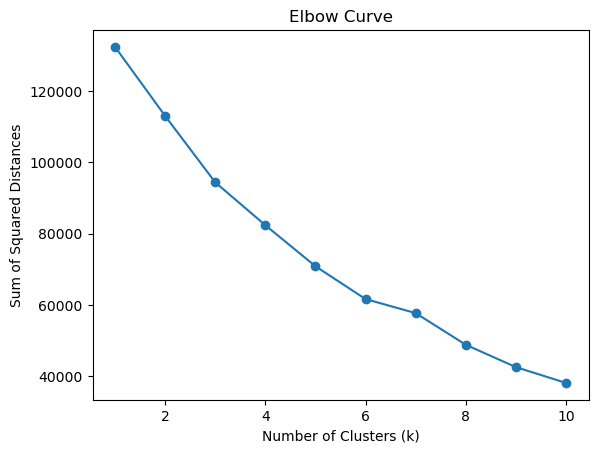

In [7]:
# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [8]:
# Based on the elbow plot
optimal_k = 8  

In [9]:
# K-means Clustering with Optimal Number of Clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_ml['Cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
# Function to get similar game names based on input game name
def get_similar_game_names(input_game, num_suggestions=3):
    input_game_lower = input_game.lower()  # Converts the input to lowercase

    try:
        # Find the row for the input game (case-insensitive)
        input_game_row = df_ml[df_ml['game'].str.lower() == input_game_lower].iloc[0]
    except IndexError:
        # If there's no exact match, suggest similar names
        all_game_names_lower = df_ml['game'].str.lower().tolist()
        similar_names = process.extract(input_game_lower, all_game_names_lower, limit=num_suggestions)
        
        suggestions = [name for name, _ in similar_names]
        
        print(f"No match found for the game '{input_game}'. You can try:")
        for suggestion in suggestions:
            print(f"- {suggestion.capitalize()}")  # Capitalizes the suggestions for better readability
        return []

    # Get features for the input game
    input_game_features = input_game_row[selected_features].values.reshape(1, -1)

    # Predict the cluster for the input game
    predicted_cluster = kmeans.predict(scaler.transform(input_game_features))[0]

    # Filter similar games in the same cluster (excluding the input game itself)
    similar_games = df_ml[(df_ml['Cluster'] == predicted_cluster) & (df_ml['game'] != input_game_row['game'])].head(num_suggestions)

    # Extract names of similar games
    similar_game_names = similar_games['game'].tolist()

    return similar_game_names

In [11]:
# Example: Input a game and get similar game names !!!!!!!limit to 3 suggestions!!!!
chosen_game = input("Please type in your desired game: ")
similar_game_names = get_similar_game_names(chosen_game, num_suggestions=3)

# Print the result
print(f"Similar Games to '{chosen_game}':")
print(similar_game_names)


Please type in your desired game: fortnite
Similar Games to 'fortnite':
['Malice', 'Palallel', 'En Route: Space']


C:\Users\nicoo\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
import hvplot.pandas
scatter_plot = df_ml.hvplot.scatter(
    x="reviewer_rating",
    y="positivity_ratio",
    by="Cluster",
    hover_cols=["game"],
    title="Scatter Plot by Game Segment - k=8"
)

# Show the plot
hvplot.show(scatter_plot)


Launching server at http://localhost:56028


In [16]:
# export the model
import pickle

def save_model():
    # ... (same computation as before)

    # Save computed data as a binary file
    with open('computed_data.pkl', 'wb') as file:
        pickle.dump({
            'df_ml': df_ml,
            'selected_features': selected_features,
            'scaler': scaler,
            'kmeans': kmeans,
        }, file)
        print("Pickle file saved successfully.")
        
save_model()

Pickle file saved successfully.
